In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

In [235]:
##### TODO
##### Ese nombre está mal! es type R!!!!
with fits.open('../profiles/voids/Rv_10-50/lensing_Rv10-50_z02-04-typeS_RMAX5.fits') as p:
    R = p[1].data.Rp
    S = p[2].data.Sigma.reshape(101,100)
    DSt = p[2].data.DSigma_T.reshape(101,100)
    DSx = p[2].data.DSigma_X.reshape(101,100)
    covS = p[3].data.covS.reshape(100,100)
    covDSt = p[3].data.covDSt.reshape(100,100)
    covDSx = p[3].data.covDSx.reshape(100,100)
    z_mean = p[0].header['z_mean']

<ErrorbarContainer object of 3 artists>

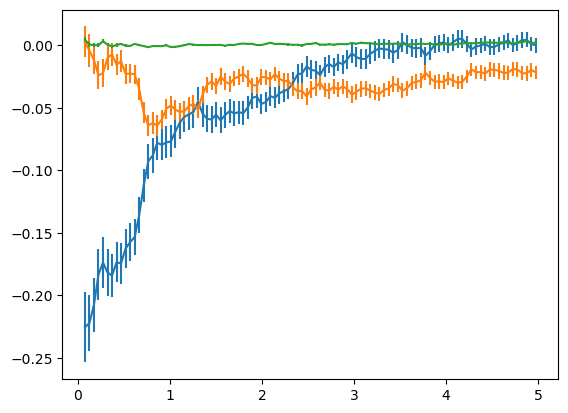

In [236]:
plt.errorbar(R, S[0],np.sqrt(np.diag(covS)))
plt.errorbar(R, DSt[0],np.sqrt(np.diag(covDSt)))
plt.errorbar(R, DSx[0],np.sqrt(np.diag(covDSx)))

# Fitting

In [144]:
from functools import partial
import emcee
import corner

In [218]:
def pm(z):
    '''densidad media en Msun/(pc**2 Mpc)'''
    h = 1.
    cosmo = LambdaCDM(H0 = 100.*h, Om0=0.3, Ode0=0.7)
    p_cr0 = cosmo.critical_density(0).to('Msun/(pc**2 Mpc)').value
    a = cosmo.scale_factor(z)
    out = p_cr0*cosmo.Om0/a**3
    return out

def hsw(r, rv, rs, a, b, dc):
    return dc*(1-(r/rs)**a)/(1+(r/rv)**b)

def sigma_hamaus(redshift, r,
                   rv,rs,a,b,dc):
    
    def integrand(z,R):
        return hsw(r=np.sqrt(z**2+R**2),rv=rv,rs=rs,dc=dc,a=a,b=b)
  
    den_integrada = quad_vec(integrand, -1e3, 1e3, args=(r,), epsrel=1e-3)[0]

    sigma = pm(redshift)*den_integrada/rv
    
    return sigma

sigma_hsw = partial(sigma_hamaus, z_mean)

def sigma_hamaus_R(redshift, r,
                   rv,rs,a,b,dc,
                   rvLSS,rsLSS,aLSS,bLSS,dcLSS):
    
    def integrand(z,R):
        return hsw(r=np.sqrt(z**2+R**2),rv=rv,rs=rs,dc=dc,a=a,b=b) + hsw(r=np.sqrt(z**2+R**2),rv=rvLSS,rs=rsLSS,dc=dcLSS,a=aLSS,b=bLSS)
  
    den_integrada = quad_vec(integrand, -1e3, 1e3, args=(r,), epsrel=1e-3)[0]

    sigma = pm(redshift)*den_integrada/rv
    
    return sigma

sigma_hsw_R = partial(sigma_hamaus_R, z_mean)

/tmp/ipykernel_91965/4055311400.py:11: RuntimeWarning: overflow encountered in power
  return dc*(1-(r/rs)**a)/(1+(r/rv)**b)


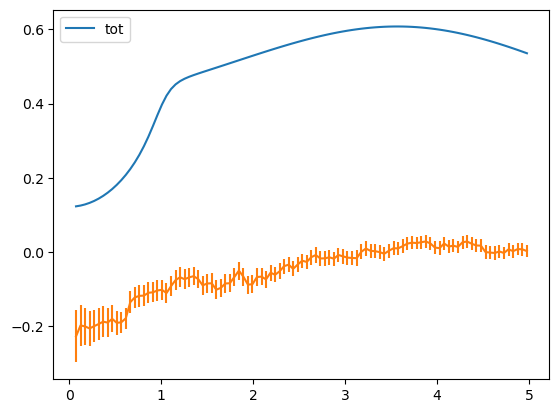

In [217]:
plt.plot(R, sigma_hsw_R(R,1.028,1.472,4.014,14.239,-0.8007,4.881,1.822,1.338,4.593,-0.154), label='tot')
# plt.plot(R, sigma_hsw(R,1.028,1.472,4.014,14.239,-0.8007), ':', label='int')
# plt.plot(R, sigma_hsw(R,4.881,1.822,1.338,4.593,-0.154), '--', label='LSS')
# plt.plot(R, 0.5*(sigma_hsw(R,1.028,1.472,4.014,14.239,-0.8007) + sigma_hsw(R,4.881,1.822,1.338,4.593,-0.154)), '.-', label='sum')
plt.errorbar(R, S[0],np.sqrt(np.diag(covS)))
plt.legend()

In [245]:
def log_likelihood(theta, x, y, iCs):
    model = sigma_hsw_R(x, *theta)

    return -np.dot((model - y), np.dot(iCs, (model - y)))

def log_prior(theta):
    rv1,rs1,a1,b1,delta1 = theta[:5]
    rvLSS,rsLSS,aLSS,bLSS,deltaLSS = theta[5:]
    if (0.7 < rs1 < 2.5)&(0.7 < rv1 < 2.5)&(-1.5 <= delta1 < 0.)&(1. < a1 < 9.)&(1. < b1 < 15.)&(
       1.0 < rsLSS < 5.)&(1.0 < rvLSS < 5.)&(-0.5 <= deltaLSS < 0.)&(1. < aLSS < 5.)&(3. < bLSS < 7.)&(aLSS<=bLSS):
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [252]:
pos = np.array([
    np.random.uniform(1.0,2.,32),
    np.random.uniform(1.0,2.,32),       #rs
    np.random.uniform(3.,7.,32),        #alpha
    np.random.uniform(7.,10.,32),
    np.random.uniform(-1.3,-0.8,32),       #delta
    
    np.random.uniform(3.,4.5,32),
    np.random.uniform(3.,4.5,32),       #rs
    np.random.uniform(1.5,3.,32),        #alpha
    np.random.uniform(5.,7.,32),
    np.random.uniform(-0.4,-0.1,32),       #delta
]).T     

nwalkers, ndim = pos.shape

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(R, S[0], np.linalg.inv(covS)), pool=pool)
    start = time.time()
    # state = sampler.run_mcmc(pos, 50, progress=True)
    # sampler.reset()
    sampler.run_mcmc(pos, 1000, progress=True)
    end = time.time()
    multi_time = end - start
print(multi_time)

OSError: [Errno 24] Too many open files

(240000, 10)


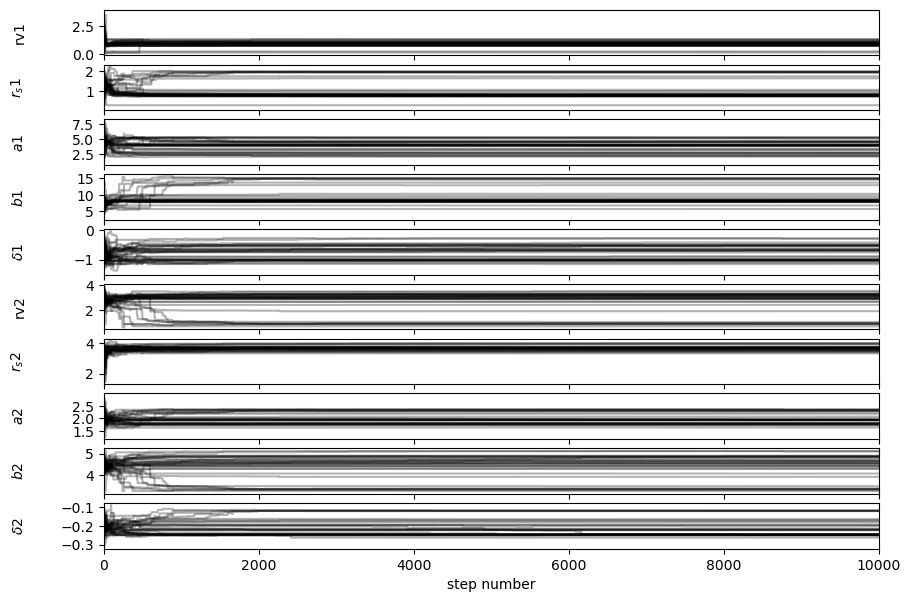

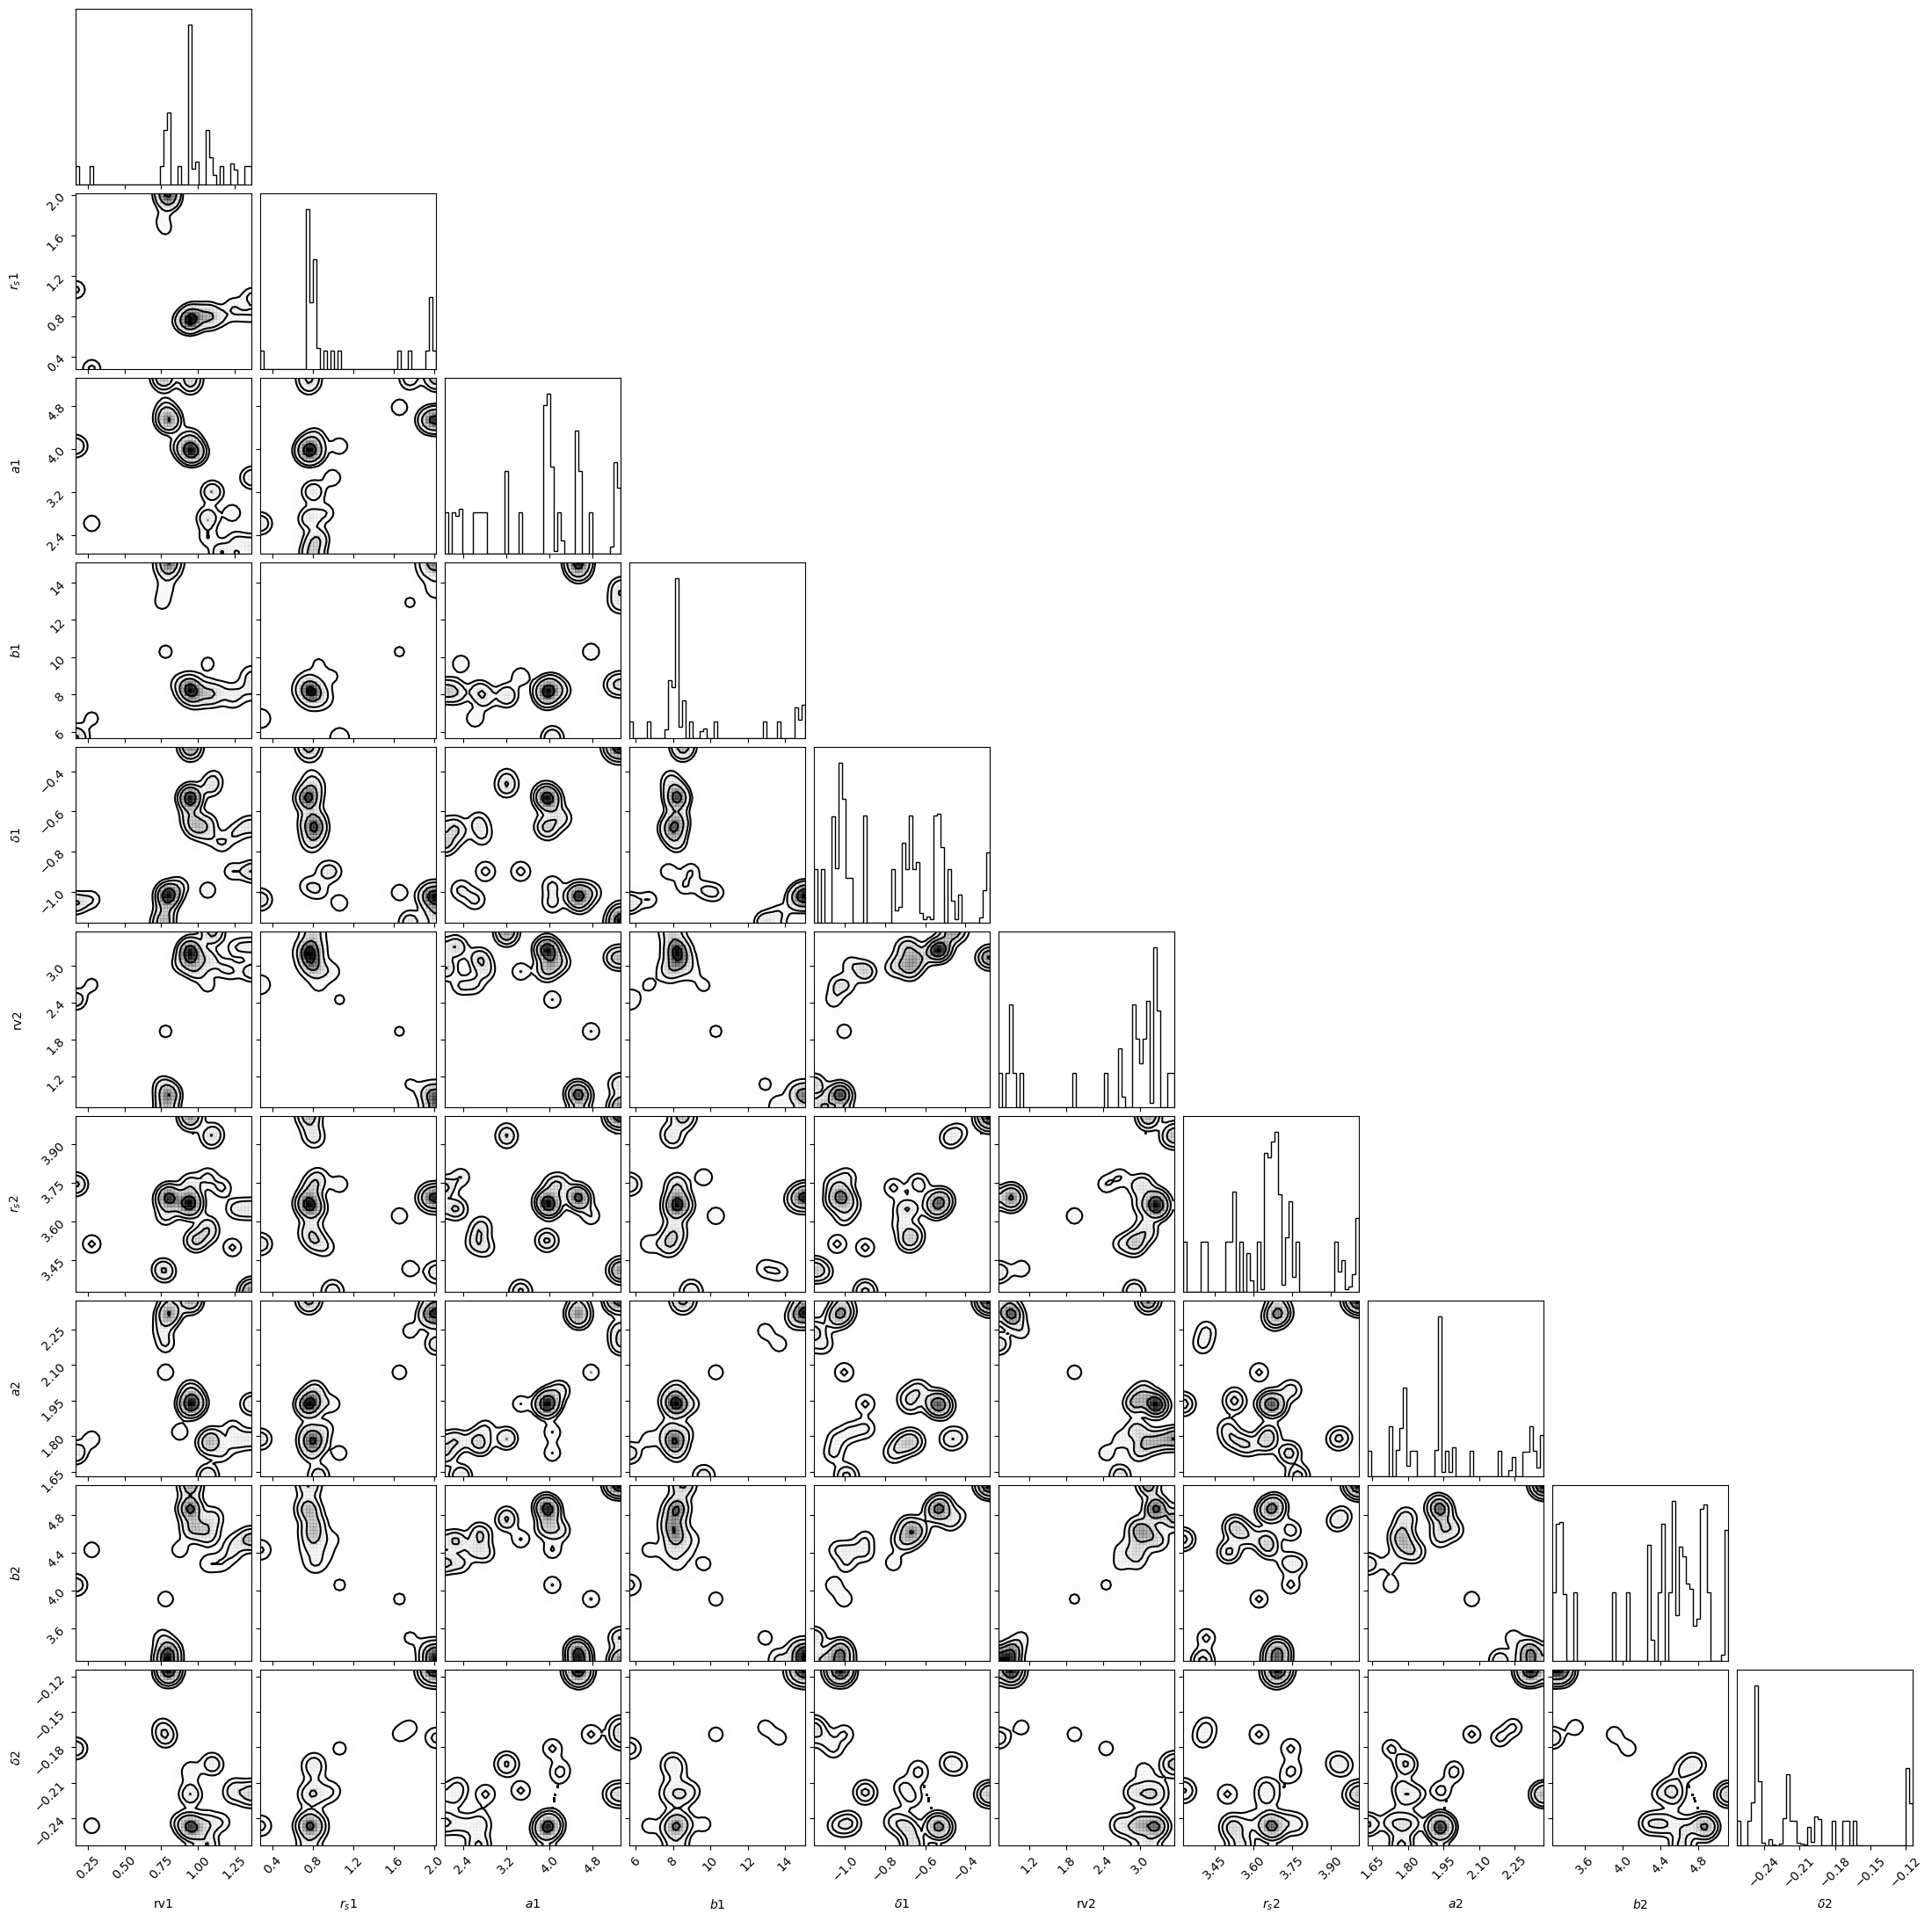

In [221]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['rv1',f'$r_s1$',f'$a1$', f'$b1$',f'$\delta1$',
         'rv2',f'$r_s2$',f'$a2$', f'$b2$',f'$\delta2$']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

flat_samples = sampler.get_chain(discard=2500, thin=1, flat=True)
print(flat_samples.shape)

fig = corner.corner(
    flat_samples, labels=labels, 
    bins=50,
    # truths=[rs_true,rv_true, delta_true,a_true, b_true], 
    smooth=2.
);

# Guardado! correr solo si es necesario pegar y guardar perfiles

In [48]:
def cov_matrix(array):
        
    K = len(array)
    Kmean = np.average(array,axis=0)
    bins = array.shape[1]
    
    COV = np.zeros((bins,bins))
    
    for k in range(K):
        dif = (array[k]- Kmean)
        COV += np.outer(dif,dif)        
    
    COV *= (K-1)/K
    return COV

In [224]:
with fits.open('/home/fcaporaso/profiles/voids/Rv_10-50/r3-5_rv9-50_Srbin_0.fits') as p:
    R_2 = p[1].data.Rp.reshape(101,40)[0]
    S_2 = p[1].data.Sigma.reshape(101,40)
    DSt_2 = p[1].data.DSigma_T.reshape(101,40)
    DSx_2 = p[1].data.DSigma_X.reshape(101,40)
    
with fits.open('/home/fcaporaso/profiles/voids/Rv_10-50/rvalto_R.fits') as p:
    R_1 = p[1].data.Rp
    S_1 = p[2].data.Sigma.reshape(101,60)
    DSt_1 = p[2].data.DSigma_T.reshape(101,60)
    DSx_1 = p[2].data.DSigma_X.reshape(101,60)

In [223]:
n = np.array([60,40])
ntot = n.sum()
R = np.zeros(ntot)
Sigma = np.zeros((101,ntot))
DSigma_T = np.zeros((101,ntot))
DSigma_X = np.zeros((101,ntot))
Ninbin = np.zeros((101,ntot))

In [225]:
R[:n[0]] = R_1
R[n[0]:] = R_2

In [226]:
Sigma[:,:n[0]] = S_1
Sigma[:,n[0]:] = S_2

DSigma_T[:,:n[0]] = DSt_1
DSigma_T[:,n[0]:] = DSt_2

DSigma_X[:,:n[0]] = DSx_1
DSigma_X[:,n[0]:] = DSx_2

In [227]:
covS   = cov_matrix(Sigma[1:,:]).flatten()
covDSt = cov_matrix(DSigma_T[1:,:]).flatten()
covDSx = cov_matrix(DSigma_X[1:,:]).flatten()

In [228]:
Nvoids    = headers[0].header['N_voids']
Rv_min    = headers[0].header['Rv_min']
Rv_max    = headers[0].header['Rv_max']
rho2_min  = headers[0].header['rho2_min']
rho2_max  = headers[0].header['rho2_max']
z_min     = headers[0].header['z_min']
z_max     = headers[0].header['z_max']
ndots     = ntot


In [233]:
Rv_mean   = headers[0].header['Rv_mean']
rho2_mean = headers[0].header['rho2_mean']
z_mean    = headers[0].header['z_mean']

In [234]:
hdu = fits.Header()
hdu.append(('N_VOIDS',int(Nvoids)))
hdu.append(('Rv_min',np.round(Rv_min,2)))
hdu.append(('Rv_max',np.round(Rv_max,2)))
hdu.append(('Rv_mean',np.round(Rv_mean,4)))
hdu.append(('rho2_min',np.round(rho2_min,2)))
hdu.append(('rho2_max',np.round(rho2_max,2)))
hdu.append(('rho2_mean',np.round(rho2_mean,4)))
hdu.append(('z_min',np.round(z_min,2)))
hdu.append(('z_max',np.round(z_max,2)))
hdu.append(('z_mean',np.round(z_mean,4)))
hdu.append(('ndots',int(ndots)))

table_r = [fits.Column(name='Rp', format='E', array=R)]

table_p = [fits.Column(name='Sigma',    format='E', array=Sigma.flatten()),
           fits.Column(name='DSigma_T', format='E', array=DSigma_T.flatten()),
           fits.Column(name='DSigma_X', format='E', array=DSigma_X.flatten()),
           fits.Column(name='Ninbin', format='E', array=Ninbin.flatten())]

table_c = [fits.Column(name='covS', format='E', array = covS),
           fits.Column(name='covDSt', format='E', array = covDSt),
           fits.Column(name='covDSx', format='E', array = covDSx)]

tbhdu_r = fits.BinTableHDU.from_columns(fits.ColDefs(table_r))
tbhdu_p = fits.BinTableHDU.from_columns(fits.ColDefs(table_p))
tbhdu_c = fits.BinTableHDU.from_columns(fits.ColDefs(table_c))
primary_hdu = fits.PrimaryHDU(header=hdu)
hdul = fits.HDUList([primary_hdu, tbhdu_r, tbhdu_p, tbhdu_c])

hdul.writeto(f'/home/fcaporaso/profiles/voids/Rv_6-10/lensing_Rv9-50_z02-04-typeS_RMAX5.fits',overwrite=True)